# Tow PACER project

### Phase 1 (preparation; Jeremy, 40 hrs; Justin, 8 hrs; between 3/1 and 4/1): 
 - Compile a close-to-live database of relevant free Federal court filings data, pulling directly from PACER RSS feeds and the CourtListener's APIs.
 - Compile training data in consultation with the courts reporter for several of his heuristics. 
 - Other preliminary infrastructure work, e.g. scraping DoJ press releases

### Phase 2 (Jeremy, 120hrs; Justin 12 hrs; between 4/1 and 6/1):
 - Build custom models (classifiers and named-entity recognizers) to instrumentalize hand-written heuristics used by the courts reporter using docket data.
 - Test those models accuracy on held-out sets and also new data, plus human evaluation/research by Justin. (Revising as necessary.)
 - Alert documents considered accurate by the model to the courts reporter via Slack.

### Phase 3 (Jeremy, 60 hours; between 6/1 and 7/1):
 - For heuristics that aren't performing as well as we'd like, purchase dockets (10cents to a few dollars each) to provide the model with more information. This is a higher stakes test for the model, since it will involve automatically spending money.
 - Fetch and store those dockets (likely in the Free Law Project's RECAP database).

### Phase 4 ("stretch goals"; if time permits):
- Devise an AI-based method, based on consultation with a courts reporter, for guessing which documents we should purchase from a case. This is a greater challenge because we're asking the model to encode newsworthiness directly, rather than a more well-defined category.

## Models:

Search warrants:
- is this maybe a search warrant (based on RSS) that we should buy the docket for?
- is [this a search warrant or not](https://colab.research.google.com/drive/16l_Fr9d9oLrGPz7cQwtD5Z3sJGsHQagD#scrollTo=2QR9UdtmiGbs)? (based on a docket)
- [what's being searched/seized](https://colab.research.google.com/drive/1bK5lsugjEX6X4QdGFmeA4KglUPQaRuPh#scrollTo=79q5hRTtHNRq)?
- what category is the thing being searched/seized? (need to generate categories)

Newsworthy: 
 - DOJ press releases, Justin's articles, whether it was purchased by a courtlistener user

In [9]:
from pacerporcupine import courtlistener
import csv
import pandas as pd
from tqdm.notebook import tqdm

# NER from full search-warrant document names

In [10]:
docs = courtlistener.find_search_warrant_documents_by_description(n=100, available_only=False)

{'type': 'r', 'order_by': 'entry_date_filed desc', 'description': 'search warrant'}


In [11]:
docs

[{'absolute_url': '/docket/59999555/3/united-states-v-sealed/',
  'assignedTo': 'Joe L. Webster',
  'assigned_to_id': 9362,
  'attachment_number': None,
  'attorney': None,
  'attorney_id': None,
  'caseName': 'United States v. SEALED',
  'cause': '',
  'court': 'District Court, M.D. North Carolina',
  'court_citation_string': 'M.D.N.C.',
  'court_exact': 'ncmd',
  'court_id': 'ncmd',
  'dateArgued': None,
  'dateFiled': '2021-05-11T00:53:00-07:00',
  'dateTerminated': '2021-06-21T00:53:00-07:00',
  'description': 'Search Warrant Returned Executed in case as to IN THE MATTER OF THE SEARCH OF ADAM WAYNE SHELTON, DOB: 10/22/1986 on 06/11/2021. (Taylor, Abby) (Entered: 06/21/2021)',
  'docketNumber': '1:21-mj-00168',
  'docket_absolute_url': '/docket/59999555/united-states-v-sealed/',
  'docket_entry_id': 167674208,
  'docket_id': 59999555,
  'document_number': 3,
  'document_type': 'PACER Document',
  'entry_date_filed': '2021-06-21T00:53:00-07:00',
  'entry_number': 3,
  'filepath_local

In [3]:
from flair.models import SequenceTagger

model = SequenceTagger.load('search_warrants_model/final-model-20210429.pt')

from flair.data import Sentence

2021-05-05 13:40:37,262 --------------------------------------------------------------------------------
2021-05-05 13:40:37,263 ACHTUNG: The key 'search_warrants_model/final-model-20210429.pt' was neither found on the ModelHub nor is this a valid path to a file on your system!
2021-05-05 13:40:37,264  -> Please check https://huggingface.co/models?filter=flair for all available models.
2021-05-05 13:40:37,265  -> Alternatively, point to a model file on your local drive.
2021-05-05 13:40:37,265 --------------------------------------------------------------------------------


UnboundLocalError: local variable 'model_path' referenced before assignment

In [6]:
for doc in docs:
    sentence = Sentence(doc["description"])
    model.predict(sentence)
    print(sentence.to_plain_string())
    print(' '.join("{}: {}".format(entity.tag, entity.text) for entity in sentence.get_spans('ner')))
    print()
    

Application and Affidavit for Search and Seizure Warrant entered as to A silver Google laptop model C0A, 8C05G06JP9 (Target Device 1). (mxn) (Entered: 04/28/2021)
PHONE: A silver Google laptop model C0A , 8C05G06JP9 ( Target Device L-PHONE: 1

Search/Seizure Warrant Returned Executed on 10/28/2020 for email account @alliedasphaltpaving.com controlled by Rackspace US, Inc.. [DESIGNATION: 1] (Johnson, Meagan) (Entered: 04/28/2021)
ONLINE_ACCOUNT: account @ alliedasphaltpaving.com controlled by Rackspace US , Inc.

AFFIDAVIT IN SUPPORT of 3 Application for Search Warrant (Redacted). (jsa)


Search/Seizure Warrant Returned Executed on 4/23/2021 for Location at 443 South Boulevard Pontiac Michigan. [DESIGNATION: 21-mc-50567] (Fairchild, Susan) (Entered: 04/26/2021)
ADDRESS: Location at 443 South Boulevard Pontiac L-ADDRESS: Michigan

APPLICATION and AFFIDAVIT by United States of America for a Search Warrant. (rb) (Entered: 04/26/2021)


Search/Seizure Warrant Returned Executed on 5/29/2020 

MOTION to UNSEAL Search Warrant and Search Warrant Affidavit by USA as to Facebook User ID 100011985227160. (Kastilahn, A) (Entered: 04/06/2021)
ONLINE_ACCOUNT: Facebook User ID 100011985227160

REDACTED VERSION of 2 Search Warrant by USA as to Sealed Bank Account (dlb) (Entered: 04/05/2021)


REDACTED VERSION of 2 Search Warrant Application by USA as to Sealed Residence (dlb) (Entered: 04/05/2021)


Application and Affidavit for Search and Seizure Warrant entered as to Purple i-phone Seizure No. 2021250600056401-0004 ("Target Device 2"). (lrc) (Entered: 04/02/2021)
PHONE: Purple i-phone Seizure No. 2021250600056401-0004 (" Target Device 2 L-PHONE: ")

APPLICATION and Affidavit for Search Warrant by USA as to Apple iPhone 978 305-2137, LG Telephone 978 876-2190 - APPROVED So Ordered by Magistrate Judge Andrea K. Johnstone. (Attachments: # 1 Affidavit) Original document available in clerks office. (bt) (Entered: 04/01/2021)
PHONE: Apple iPhone 978 305-2137 , LG Telephone 978 L-PHONE: 87

Application for Search Warrant as to In the matter of the search of the person known and described as Christopher Acevedo a/k/a ESSAY" DOB XXXXXXXXXX. Ordered by Magistrate Judge Ramon E. Reyes, Jr on 3/22/2021. (Sica, Michele) (Entered: 03/22/2021)
MULTIPLE: DOB L-ADDRESS: XXXXXXXXXX

Search Warrant Returned Executed on 3/19/21 in case as to 4101 Highway 93 South, Unit 164, Missoula, MT 59804 (APP) (Entered: 03/23/2021)
ADDRESS: 4101 Highway 93 South , Unit 164 , Missoula , MT L-ADDRESS: 59804

Application and Affidavit for Search and Seizure Warrant entered as to UMX/SN:683C70419064808 2021250690003201-0004 ("Target Device 2"). (lrc) (Entered: 03/19/2021)
PHONE: UMX / SN : 683C70419064808 2021250690003201-0004 (" Target Device L-PHONE: 2

APPLICATION AND AFFIDAVIT FOR SEARCH WARRANT by USA as to APPLE IPHONES SEIZED ON MARCH 11, 2021. (mqe) (Entered: 03/19/2021)
PHONE: APPLE IPHONES SEIZED ON MARCH 11 , L-PHONE: 2021

APPLICATION AND AFFIDAVIT by United States of America as to Search

Application for Search Warrant as to Information Associated With Facebook Usernames "Zabar Stacks (Bushwick Baby)"; "Zabar Aaron Stacks (Bushwick Baby)"; And Irick Zabar (Mario World Wowo)" And Instagram Username "Barbarthirtydays" That Is Stored At Premises Controlled By Facebook Inc. Ordered by Chief Magistrate Cheryl L. Pollak on 3/11/2021. (Piper, Francine) (Entered: 03/11/2021)
ONLINE_ACCOUNT: Information Associated With Facebook Usernames " Zabar Stacks ( Bushwick Baby )" ; " Zabar Aaron Stacks ONLINE_ACCOUNT: Instagram Username " Barbarthirtydays " That Is Stored At Premises Controlled By Facebook Inc

Application and Affidavit for Search and Seizure Warrant entered as to Pink iPhone Seizure No. 2021250600044701-004 "Target Device 1". (aef) (Entered: 03/11/2021)
PHONE: Pink iPhone Seizure No. 2021250600044701-004 " Target Device L-PHONE: 1

APPLICATION and Affidavit for Search Warrant by Affiant Daniel L. Snyder as to 1014 South Perry Street Denver, CO 80219. (trvo, ) (Entered: 

## labeling the categories of searched-things

should we do NER to extract the single entity, and then classify those separately? Or do it all in one step, extracting with NER the phone category, the car category, etc.?

In [7]:
if False:
    docs = courtlistener.find_search_warrant_documents(n=1000, available_only=False)
    with open('extracted_objects.csv', 'w') as csvfile:
        spamwriter = csv.writer(csvfile)
        spamwriter.writerow(["thing_searched", "url", "object_type"])
        for doc in docs:
            sentence = Sentence(doc["description"])        
            model.predict(sentence)
            thing_searched = ' '.join(entity.text for entity in sentence.get_spans('ner'))
            if thing_searched:
                spamwriter.writerow([thing_searched, doc["absolute_url"], ""])

### Label by hand
https://docs.google.com/spreadsheets/d/1F6sL4tSxDdISYDZEYVLtYBINlCoZIvQoxKKt_OA3TVU/edit#gid=1467230407

then, add the labels in convert_prodigy_annots.py and re-train the FLAIR model to get final-model-20210429.pt.

## wiring it all up

FIRST:

1. every day, get all the new CL docs matching "warrant"
2. filter them by is-it-a-search-warrant-or-not
3. extract named-entities (classified)
5. send an email like:
```
today's search warrants:

cars:
 - US v. A Toyota (cacd)
 - US v. A Mitsubishi VIN #WHATEVER (gand)
 
people:
 - adsfasdfasd
 - asdfasdf
```

EVENTUALLY:
1. every day, get all the all the RSS docket entries
2. filter them by the RSS docket entry version of is-it-a-search-warrant-or-not
3. every day, get all the new CL docs matching "warrant" 
4. filter them by the document is-it-a-search-warrant-or-not OR fetched from the RSS docket entry bit
5. continue as before


In [4]:
from flair.models import SequenceTagger
from flair.data import Sentence

ner_model = SequenceTagger.load('pacerporcupine/models/flairner/final-model-20210429.pt')



2021-05-05 13:43:07,401 loading file pacerporcupine/models/flairner/final-model-20210429.pt


In [5]:

# start_date = "04/11/2021"
# docs = courtlistener.find_search_warrant_documents(n=500, filed_after=start_date)
# for doc in search_warrants.iterrows():
#     sentence = Sentence(doc["description"])        
#     ner_model.predict(sentence)
#     thing_searched = ' '.join(entity.text for entity in sentence.get_spans('ner'))
#     if thing_searched:
#         print("{}   ".format(doc["caseName"], doc["court_id"]))
#         if thing_searched.replace(" ", '').replace(",", '') not in doc["caseName"].replace(" ", '').replace(",", ''):
#             print(thing_searched)
#         print()


In [6]:
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from keras.preprocessing.sequence import pad_sequences
from torch import tensor, device, no_grad
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from scipy.special import softmax
MAX_LEN = 64
my_device = device("cpu")

# casename_shortdesc_tokenizer = BertTokenizer.from_pretrained("search_warrants_model/classifier/casename_shortdesc_model/")
# casename_shortdesc_model = BertForSequenceClassification.from_pretrained("search_warrants_model/classifier/casename_shortdesc_model/")

# casename_desc_tokenizer = BertTokenizer.from_pretrained("search_warrants_model/classifier/casename_desc_model/")
# casename_desc_model = BertForSequenceClassification.from_pretrained("search_warrants_model/classifier/casename_desc_model/")


In [10]:
from datetime import datetime, timedelta
import pacerporcupine.courtlistener_search_warrant_alerter.alert as courtlistener_search_warrant_alerter

casename_desc_classifier = courtlistener_search_warrant_alerter.Classifier("pacerporcupine/pacerporcupine/models/classifier/casename_desc_model/")
ner = courtlistener_search_warrant_alerter.NamedEntityRecognizer( "pacerporcupine/pacerporcupine/models/flairner/final-model-20210429.pt")

start_date = (
    datetime.today() - timedelta(days=7)
).strftime("%m/%d/%Y")

docs = courtlistener.find_search_warrant_documents_by_description(
    n=500, filed_after=start_date, available_only=False
)
docs_df = pd.DataFrame(docs)

print("found {} possible search warrants".format(docs_df.shape[0]))
docs_df["to_classify"] = docs_df.caseName + " " + docs_df.description
docs_df = casename_desc_classifier.predict(docs_df, "description")
search_warrants = docs_df[docs_df["predicted_class"] == 1]
print(
    "of which, {} are search warrants according to the model".format(
        search_warrants.shape[0]
    )
)
category_cases = courtlistener_search_warrant_alerter.classify_cases_by_searched_object_category(ner, search_warrants)
for i, category in enumerate(category_cases.keys()):
    cases = category_cases[category]
    print(category)
    for case in cases:
        print(case)
    print("")
    if i + 1 != len(category_cases.keys()):
        print("----------------------")
        print("")


2021-05-05 13:45:21,640 loading file pacerporcupine/models/flairner/final-model-20210429.pt
{'type': 'r', 'order_by': 'entry_date_filed desc', 'filed_after': '04/28/2021', 'description': 'search warrant'}
found 44 possible search warrants


  0%|          | 0/39 [00:00<?, ?it/s]

of which, 39 are search warrants according to the model


100%|██████████| 39/39 [01:20<00:00,  2.07s/it]

PHONE
- United States v. In Re: Motorola Telephone with White Back    vtd
  https://www.courtlistener.com//docket/59878807/1/united-states-v-in-re-motorola-telephone-with-white-back/
- United States v. In Re: Motorola Telephone with White Back    vtd
  https://www.courtlistener.com//docket/59878807/1/1/united-states-v-in-re-motorola-telephone-with-white-back/
- United States v. In Re: Motorola Telephone with White Back    vtd
  https://www.courtlistener.com//docket/59878807/1/2/united-states-v-in-re-motorola-telephone-with-white-back/
- United States v. In Re: Motorola Telephone with White Back    vtd
  https://www.courtlistener.com//docket/59878807/1/3/united-states-v-in-re-motorola-telephone-with-white-back/
- United States v. Information associated with cellular telephone numbers (571) 621-3000 and (571) 331-4188, that are stored at premises controlled by T-Mobile US, Inc.    rid
  https://www.courtlistener.com//docket/59878597/2/united-states-v-information-associated-with-cellular-

## wiring-up the PACER RSS alerter


In [2]:
from sqlalchemy import create_engine
import pandas as pd
from os import environ
live_engine = create_engine(environ.get("LIVE_DATABASE_URL"))

docs_df = pd.read_sql("""
    select * from rss_docket_entries where document_type ilike '%%warrant%%' and pub_date > %(start_date)s;
    """, live_engine, params={"start_date": "2021-05-10"})
docs_df.head(8)


,title,case_number,case_name,docket_id,description,document_type,guid,pub_date,court,scrape_date,docket_entry_seq_num,docket_entry_num
0,5:06-cr-00214-1 United States of America v. Fr...,5:06-cr-00214-1,United States of America v. Frierson,62897,[Petition for Warrant or Summons for Offender ...,Petition for Warrant or Summons for Offender U...,https://ecf.okwd.uscourts.gov/cgi-bin/DktRpt.p...,2021-05-10 20:56:38,okwd,2021-05-10 22:06:17.531112,600.0,188.0
1,3:21-mj-00170-1 USA v. Evans,3:21-mj-00170-1,USA v. Evans,255225,"[Warrant Returned Executed] (<a href=""https://...",Warrant Returned Executed,https://ecf.ohsd.uscourts.gov/cgi-bin/DktRpt.p...,2021-05-10 19:51:42,ohsd,2021-05-10 22:06:11.033254,28.0,7.0
2,2:21-cr-00079-1 USA v. Heintz,2:21-cr-00079-1,USA v. Heintz,255208,"[Warrant Returned Executed] (<a href=""https://...",Warrant Returned Executed,https://ecf.ohsd.uscourts.gov/cgi-bin/DktRpt.p...,2021-05-10 19:30:05,ohsd,2021-05-10 22:06:11.410481,68.0,22.0
3,1:21-mj-00345-1 USA v. SEALED,1:21-mj-00345-1,USA v. SEALED,254469,"[Search Warrant Returned Executed] (<a href=""h...",Search Warrant Returned Executed,https://ecf.ohsd.uscourts.gov/cgi-bin/DktRpt.p...,2021-05-10 10:47:42,ohsd,2021-05-10 22:06:15.196542,8.0,3.0
4,1:21-mj-00344-1 USA v. SEALED,1:21-mj-00344-1,USA v. SEALED,254467,"[Search Warrant Returned Executed] (<a href=""h...",Search Warrant Returned Executed,https://ecf.ohsd.uscourts.gov/cgi-bin/DktRpt.p...,2021-05-10 10:46:02,ohsd,2021-05-10 22:06:15.211170,8.0,3.0
5,5:12-cr-00120-5 United States of America v. He...,5:12-cr-00120-5,United States of America v. Herrera et al,83843,[Petition for Warrant or Summons for Offender ...,Petition for Warrant or Summons for Offender U...,https://ecf.okwd.uscourts.gov/cgi-bin/DktRpt.p...,2021-05-10 14:07:32,okwd,2021-05-10 22:06:20.012445,1365.0,446.0
6,5:13-cr-00055-1 United States of America v. Di...,5:13-cr-00055-1,United States of America v. Dirden,86430,[Petition for Warrant or Summons for Offender ...,Petition for Warrant or Summons for Offender U...,https://ecf.okwd.uscourts.gov/cgi-bin/DktRpt.p...,2021-05-10 20:37:56,okwd,2021-05-10 22:06:17.750467,138.0,52.0
7,5:21-mj-00247-1 United States of America v. Se...,5:21-mj-00247-1,United States of America v. Search Warrant,113767,"[Search Warrant Returned Executed] (<a href=""h...",Search Warrant Returned Executed,https://ecf.okwd.uscourts.gov/cgi-bin/DktRpt.p...,2021-05-10 15:51:42,okwd,2021-05-10 22:06:19.416013,8.0,3.0


In [36]:
import pacerporcupine.courtlistener_search_warrant_alerter.alert as courtlistener_search_warrant_alerter
casename_shortdesc_classifier = courtlistener_search_warrant_alerter.Classifier("pacerporcupine/pacerporcupine/models/classifier/casename_shortdesc_model/")


ensure_models_exist pacerporcupine/pacerporcupine/models/classifier/casename_shortdesc_model


In [37]:
print("found {} possible search warrants".format(docs_df.shape[0]))
docs_df["case_name"] = docs_df["case_name"].str.replace("USA v.", "United States v.")
docs_df["to_classify"] = docs_df.case_name + " " + docs_df.document_type
docs_df = casename_shortdesc_classifier.predict(docs_df, "to_classify")
search_warrants_document_type = docs_df[docs_df["predicted_class"] == 1].copy()
print(
    "of which, {} are search warrants according to the model".format(
        search_warrants_document_type.shape[0]
    )
)


found 2270 possible search warrants
of which, 581 are search warrants according to the model


In [43]:
## just to check, look at the non-search_warrants
docs_df[docs_df["predicted_class"] == 0][["case_name", "document_type"]]
# docs_df[docs_df["predicted_class"] == 1]

,case_name,document_type
0,United States of America v. Frierson,Petition for Warrant or Summons for Offender U...
1,United States v. Heintz,Warrant Returned Executed
2,United States v. Evans,Warrant Returned Executed
5,United States v. Garcia et al,Warrant Returned Executed
6,United States of America v. Dirden,Petition for Warrant or Summons for Offender U...
...,...,...
2264,United States v. Valverde-Santos,Warrant Returned Executed
2265,United States v. SEALED,Motion to SEAL Search Warrant Documents
2266,United States v. SEALED,Motion to SEAL Search Warrant Documents
2267,United States v. Villalobos,Affidavit - Out-of-District Warrant


In [38]:
# # search_warrants from "to_classify"
common = search_warrants.merge(search_warrants_document_type,on=['title','docket_id'])
search_warrants[(~search_warrants.title.isin(common.title))&(~search_warrants.docket_id.isin(common.docket_id))]
# search_warrants_document_type[search_warrants_document_type["case_name"].str.contains("SEALED")]

,title,case_number,case_name,docket_id,description,document_type,guid,pub_date,court,scrape_date,docket_entry_seq_num,docket_entry_num,to_classify,input_ids,attention_masks,predicted_class,likelihood,caseName,court_id,absolute_url
218,"3:21-mj-01870-1 USA v. T-Mobile US, Incorporat...",3:21-mj-01870-1,"USA v. T-Mobile US, Incorporated 4 Sylvan Way,...",707058,"USA v. T-Mobile US, Incorporated 4 Sylvan Way,...",Application and Affidavit for Warrant,https://ecf.casd.uscourts.gov/cgi-bin/DktRpt.p...,2021-05-10 21:50:39,casd,2021-05-11 22:12:34.936450,4.0,1.0,"USA v. T-Mobile US, Incorporated 4 Sylvan Way,...","[101, 3915, 1058, 1012, 1056, 1011, 4684, 2149...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,0.965218,"USA v. T-Mobile US, Incorporated 4 Sylvan Way,...",casd,https://ecf.casd.uscourts.gov/cgi-bin/DktRpt.p...
1343,"3:21-mj-01962-1 USA v. T-Mobile US, lncorporat...",3:21-mj-01962-1,"USA v. T-Mobile US, lncorporated 4 Sylvan Way,...",707675,"USA v. T-Mobile US, lncorporated 4 Sylvan Way,...",Application and Affidavit for Warrant,https://ecf.casd.uscourts.gov/cgi-bin/DktRpt.p...,2021-05-18 22:01:50,casd,2021-05-19 20:39:23.251673,4.0,1.0,"USA v. T-Mobile US, lncorporated 4 Sylvan Way,...","[101, 3915, 1058, 1012, 1056, 1011, 4684, 2149...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,0.990066,"USA v. T-Mobile US, lncorporated 4 Sylvan Way,...",casd,https://ecf.casd.uscourts.gov/cgi-bin/DktRpt.p...
1370,"3:21-mj-01982-1 USA v. AT&T Inc., 11760 U.S. H...",3:21-mj-01982-1,"USA v. AT&T Inc., 11760 U.S. Highway One, Suit...",707677,"USA v. AT&T Inc., 11760 U.S. Highway One, Suit...",Application and Affidavit for Warrant,https://ecf.casd.uscourts.gov/cgi-bin/DktRpt.p...,2021-05-18 21:40:55,casd,2021-05-19 20:39:24.491755,4.0,1.0,"USA v. AT&T Inc., 11760 U.S. Highway One, Suit...","[101, 3915, 1058, 1012, 2012, 1004, 1056, 4297...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,0.824449,"USA v. AT&T Inc., 11760 U.S. Highway One, Suit...",casd,https://ecf.casd.uscourts.gov/cgi-bin/DktRpt.p...
1378,"3:21-mj-01981-1 USA v. T-Mobile US, Incorporat...",3:21-mj-01981-1,"USA v. T-Mobile US, Incorporated 4 Sylvan Way,...",707672,"USA v. T-Mobile US, Incorporated 4 Sylvan Way,...",Application and Affidavit for Warrant,https://ecf.casd.uscourts.gov/cgi-bin/DktRpt.p...,2021-05-18 21:02:17,casd,2021-05-19 20:39:27.851101,4.0,1.0,"USA v. T-Mobile US, Incorporated 4 Sylvan Way,...","[101, 3915, 1058, 1012, 1056, 1011, 4684, 2149...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,0.874827,"USA v. T-Mobile US, Incorporated 4 Sylvan Way,...",casd,https://ecf.casd.uscourts.gov/cgi-bin/DktRpt.p...


In [39]:
from pacerporcupine.models import fetch
from flair.models import SequenceTagger

class NamedEntityRecognizer:
    def __init__(self, model_path):
        fetch.ensure_models_exist(
            model_path.replace("/tmp/pacerporcupine/", "").strip("/")
        )
        self.ner_model = SequenceTagger.load(model_path)

ner = NamedEntityRecognizer( "/tmp/pacerporcupine/models/flairner/final-model-20210429.pt")

ensure_models_exist models/flairner/final-model-20210429.pt
downloading pacerporcupine/models/flairner/final-model-20210429.pt to /tmp/pacerporcupine/models/flairner/final-model-20210429.pt
2021-06-01 12:41:43,076 loading file /tmp/pacerporcupine/models/flairner/final-model-20210429.pt


In [40]:
search_warrants["caseName"] = search_warrants.case_name.replace("USA v.", "United States v.")
search_warrants["court_id"] = search_warrants.court
search_warrants["absolute_url"] = search_warrants.guid
search_warrants["description"] = search_warrants.case_name.replace("USA v.", "United States v.") # try Search/Seizure Warrant Returned Executed on 8/5/2020 for
category_cases = courtlistener_search_warrant_alerter.classify_cases_by_searched_object_category(ner, search_warrants)
for i, category in enumerate(category_cases.keys()):
    cases = category_cases[category]
    print(category)
    for case in cases:
        print(case)
    print("")
    if i + 1 != len(category_cases.keys()):
        print("----------------------")
        print("")


100%|██████████| 363/363 [02:23<00:00,  2.54it/s]

no category detected
- United States of America v. Search Warrant    okwd
  https://www.courtlistener.comhttps://ecf.okwd.uscourts.gov/cgi-bin/DktRpt.pl?113767&8
- USA v. Suppressed    moed
  https://www.courtlistener.comhttps://ecf.moed.uscourts.gov/cgi-bin/DktRpt.pl?184645&21
- USA v. White iPhone Seizure No. 2021250400197301-0005 (&quot;Target Device&quot;)    casd
  https://www.courtlistener.comhttps://ecf.casd.uscourts.gov/cgi-bin/DktRpt.pl?707359&4
- USA v. Black AT&amp;T Cell Phone Seizure No. 2021250400194002-0001 (&quot;Target Device 2&quot;)    casd
  https://www.courtlistener.comhttps://ecf.casd.uscourts.gov/cgi-bin/DktRpt.pl?707109&4
- Application by the United States for a Search Warrant for One Cellphone for Investigation of 18 U.S.C. &#167; 1591 and Other Offenses    cand
  https://www.courtlistener.comhttps://ecf.cand.uscourts.gov/cgi-bin/DktRpt.pl?377756&9
- USA v. LG Cell Phone and Samsung Cell Phone    ilcd
  https://www.courtlistener.comhttps://ecf.ilcd.uscourts.gov

In [41]:
# just exploring what it thought was a search warrant
# with pd.option_context('display.max_rows', 500):
#     display(search_warrants.groupby(["case_name", "document_type"]).agg({"case_number": len}).sort_values("case_number", ascending=False)) #need display to show the dataframe when using with in jupyter
search_warrants

,title,case_number,case_name,docket_id,description,document_type,guid,pub_date,court,scrape_date,docket_entry_seq_num,docket_entry_num,to_classify,input_ids,attention_masks,predicted_class,likelihood,caseName,court_id,absolute_url
10,5:21-mj-00247-1 United States of America v. Se...,5:21-mj-00247-1,United States of America v. Search Warrant,113767,United States of America v. Search Warrant,Search Warrant Returned Executed,https://ecf.okwd.uscourts.gov/cgi-bin/DktRpt.p...,2021-05-10 15:51:42,okwd,2021-05-10 22:06:19.416013,8.0,3.0,United States of America v. Search Warrant Sea...,"[101, 2142, 2163, 1997, 2637, 1058, 1012, 3945...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",1,0.998566,United States of America v. Search Warrant,okwd,https://ecf.okwd.uscourts.gov/cgi-bin/DktRpt.p...
35,4:20-mj-00320-1 USA v. Suppressed,4:20-mj-00320-1,USA v. Suppressed,184645,USA v. Suppressed,Search/PLI Warrant Returned Executed,https://ecf.moed.uscourts.gov/cgi-bin/DktRpt.p...,2021-05-12 18:41:13,moed,2021-05-13 18:05:14.370959,21.0,7.0,USA v. Suppressed Search/PLI Warrant Returned ...,"[101, 3915, 1058, 1012, 13712, 3945, 1013, 202...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...",1,0.977169,USA v. Suppressed,moed,https://ecf.moed.uscourts.gov/cgi-bin/DktRpt.p...
64,3:21-mj-01792-1 USA v. White iPhone Seizure No...,3:21-mj-01792-1,USA v. White iPhone Seizure No. 20212504001973...,707359,USA v. White iPhone Seizure No. 20212504001973...,Application and Affidavit for Warrant,https://ecf.casd.uscourts.gov/cgi-bin/DktRpt.p...,2021-05-13 22:18:55,casd,2021-05-14 22:40:51.274130,4.0,1.0,USA v. White iPhone Seizure No. 20212504001973...,"[101, 3915, 1058, 1012, 2317, 18059, 18634, 20...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,0.998913,USA v. White iPhone Seizure No. 20212504001973...,casd,https://ecf.casd.uscourts.gov/cgi-bin/DktRpt.p...
76,3:21-mj-01881-1 USA v. Black AT&amp;T Cell Pho...,3:21-mj-01881-1,USA v. Black AT&amp;T Cell Phone Seizure No. 2...,707109,USA v. Black AT&amp;T Cell Phone Seizure No. 2...,Application and Affidavit for Warrant,https://ecf.casd.uscourts.gov/cgi-bin/DktRpt.p...,2021-05-11 18:46:57,casd,2021-05-12 18:02:18.281393,4.0,1.0,USA v. Black AT&amp;T Cell Phone Seizure No. 2...,"[101, 3915, 1058, 1012, 2304, 2012, 1004, 2371...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,0.999012,USA v. Black AT&amp;T Cell Phone Seizure No. 2...,casd,https://ecf.casd.uscourts.gov/cgi-bin/DktRpt.p...
82,1:21-mj-70748-1 Application by the United Stat...,1:21-mj-70748-1,Application by the United States for a Search ...,377756,Application by the United States for a Search ...,Search Warrant Returned Executed,https://ecf.cand.uscourts.gov/cgi-bin/DktRpt.p...,2021-05-10 16:27:02,cand,2021-05-11 16:09:22.048245,NaN,NaN,Application by the United States for a Search ...,"[101, 4646, 2011, 1996, 2142, 2163, 2005, 1037...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,0.998971,Application by the United States for a Search ...,cand,https://ecf.cand.uscourts.gov/cgi-bin/DktRpt.p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722,3:21-mj-00514-1 USA v. Search Warrant,3:21-mj-00514-1,USA v. Search Warrant,144591,USA v. Search Warrant,Application for Sealed Search Warrant,https://ecf.ctd.uscourts.gov/cgi-bin/DktRpt.pl...,2021-05-24 14:21:28,ctd,2021-05-25 14:22:38.644797,8.0,1.0,USA v. Search Warrant Application for Sealed S...,"[101, 3915, 1058, 1012, 3945, 10943, 4646, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...",1,0.992281,USA v. Search Warrant,ctd,https://ecf.ctd.uscourts.gov/cgi-bin/DktRpt.pl...
1746,3:21-mj-02062-1 USA v. Priority Mail Parcel 94...,3:21-mj-02062-1,USA v. Priority Mail Parcel 9400 1082 0549 717...,708213,USA v. Priority Mail Parcel 9400 1082 0549 717...,Application and Affidavit for Warrant,https://ecf.casd.uscourts.gov/cgi-bin/DktRpt.p...,2021-05-24 21:33:22,casd,2021-05-25 14:21:12.043601,4.0,1.0,USA v. Priority Mail Parcel 9400 1

### baseline for search warrant or not

versus the search-warrant-or-not *classifier*, how's this for a baseline?

True if case name or document type matches "search" or "tracking" or "pen register" or "seizure" else False

In [47]:
see Colab

# what documents are UNBOUGHT search warrant dockets?
NEW GOAL: get EVERYTHING then assign it a search warrant probability

In [32]:
from sqlalchemy import create_engine
import pandas as pd
from os import environ
live_engine = create_engine(environ.get("LIVE_DATABASE_URL"))


In [33]:
pd.read_sql("""
    select document_type, count(*) from rss_docket_entries where document_type ilike '%%warrant%%' group by document_type order by count(*) desc;
    """, live_engine).head(20)
# some apparent search warrants call under "Magistrate Miscellaneous Matter: Warrants/Appl"
# but others may be arrest warrants (which we don't care about)

,document_type,count
0,Warrant Returned Executed,2951
1,Warrant Issued,496
2,Magistrate Miscellaneous Matter: Warrants/Appl...,456
3,Application and Affidavit for Warrant,301
4,Search Warrant Returned Executed,286
5,Search Warrant Returned Executed,199
6,Warrant Returned Executed,185
7,Search Warrant Issued,153
8,Sealed Search Warrant Issued,144
9,Arrest Warrant Returned Executed,130


In [49]:
# what case types are most search warrants?
pd.read_sql("""
    select substring(case_number, 6, 2), count(*) 
      from rss_docket_entries 
     where (document_type ilike '%%warrant%%' and document_type ilike '%%search%%') 
        or (case_name ilike '%%search%%' and case_name ilike '%%warrant%%') 
 --        or (case_name ilike '%%phone%%')         
    group by substring(case_number, 6, 2) 
    order by count(*) desc;
    """, live_engine).head(20)
# mostly mj

,substring,count
0,mj,3605
1,cm,212
2,mb,86
3,mc,29
4,cr,17
5,sc,3
6,sw,2


In [53]:
# a few courts have "sw" as a case type
pd.read_sql("""select court, count(*) from rss_docket_entries where substring(case_number, 6, 2) = 'sw' group by court""", live_engine)

,court,count
0,cod,6
1,dcd,14
2,mowd,6
3,rid,37


In [12]:
# one such court (with "sw" case type) also haas warrants under other case types, namely sc
display(pd.read_sql("""
    select substring(case_number, 6, 2), court, count(*) 
      from rss_docket_entries 
     where (
         (document_type ilike '%%warrant%%' and document_type ilike '%%search%%')
      or (case_name ilike '%%search%%' and case_name ilike '%%warrant%%')  )
    and substring(case_number, 6, 2) != 'sw' 
    and court in ('cod', 'dcd', 'mowd', 'rid')
    group by substring(case_number, 6, 2), court 
    order by count(*) desc;
    """, live_engine).head(20))

pd.read_sql("select * from rss_docket_entries where substring(case_number, 6, 2) = 'sc'", live_engine)

,substring,court,count
0,sc,dcd,3


,title,case_number,case_name,docket_id,description,document_type,guid,pub_date,court,scrape_date,docket_entry_seq_num,docket_entry_num
0,1:21-sc-01192 INFORMATION ASSOCIATED WITH ONE ...,1:21-sc-01192,INFORMATION ASSOCIATED WITH ONE ACCOUNT STORED...,229873,[Application for Search/Seizure Warrant- 18 U....,Application for Search/Seizure Warrant- 18 U.S...,https://ecf.dcd.uscourts.gov/cgi-bin/DktRpt.pl...,2021-04-09 21:22:53,dcd,2021-04-09 22:25:21.779756,4.0,1.0
1,6:21-sc-99999 State Court Records,6:21-sc-99999,State Court Records,117721,"[State Court Records - UPLOAD] (<a href=""https...",State Court Records - UPLOAD,https://ecf.vawd.uscourts.gov/cgi-bin/DktRpt.p...,2021-05-04 14:47:38,vawd,2021-05-05 14:10:11.462031,275.0,4.0
2,1:21-sc-00446 APPLICATION FOR SEARCH OF INFORM...,1:21-sc-00446,APPLICATION FOR SEARCH OF INFORMATION ASSOCIAT...,227181,[Case Unsealed],Case Unsealed,https://ecf.dcd.uscourts.gov/cgi-bin/DktRpt.pl...,2021-04-21 15:29:51,dcd,2021-04-22 16:02:51.858778,NaN,NaN
3,1:21-sc-00446 APPLICATION FOR SEARCH OF INFORM...,1:21-sc-00446,APPLICATION FOR SEARCH OF INFORMATION ASSOCIAT...,227181,"[Order on Motion to Unseal Case] (<a href=""htt...",Order on Motion to Unseal Case,https://ecf.dcd.uscourts.gov/cgi-bin/DktRpt.pl...,2021-04-21 15:29:06,dcd,2021-04-22 16:02:51.863988,18.0,7.0
4,6:21-sc-99999 State Court Records,6:21-sc-99999,State Court Records,117721,"[State Court Records - UPLOAD] (<a href=""https...",State Court Records - UPLOAD,https://ecf.vawd.uscourts.gov/cgi-bin/DktRpt.p...,2021-04-23 16:56:34,vawd,2021-04-23 22:09:27.218927,273.0,3.0
5,7:21-sc-99999 State Court Records,7:21-sc-99999,State Court Records,117701,"[State Court Records - UPLOAD] (<a href=""https...",State Court Records - UPLOAD,https://ecf.vawd.uscourts.gov/cgi-bin/DktRpt.p...,2021-04-29 14:28:55,vawd,2021-04-30 14:09:41.588989,305.0,19.0
6,1:21-sc-00394 INFORMATION ASSOCIATED WITH TWO ...,1:21-sc-00394,INFORMATION ASSOCIATED WITH TWO INSTAGRAM ACCO...,226982,[Case Unsealed],Case Unsealed,https://ecf.dcd.uscourts.gov/cgi-bin/DktRpt.pl...,2021-05-11 15:00:13,dcd,2021-05-12 14:02:18.700042,NaN,NaN
7,1:21-sc-00194 NFORMATION ASSOCIATED WITH ONE A...,1:21-sc-00194,NFORMATION ASSOCIATED WITH ONE ACCOUNT STORED ...,226297,"[Order on Motion to Unseal Case] (<a href=""htt...",Order on Motion to Unseal Case,https://ecf.dcd.uscourts.gov/cgi-bin/DktRpt.pl...,2021-05-11 14:55:24,dcd,2021-05-12 14:02:18.770149,19.0,7.0
8,1:21-sc-00394 INFORMATION ASSOCIATED WITH TWO ...,1:21-sc-00394,INFORMATION ASSOCIATED WITH TWO INSTAGRAM ACCO...,226982,"[Order on Motion to Unseal Case] (<a href=""htt...",Order on Motion to Unseal Case,https://ecf.dcd.uscourts.gov/cgi-bin/DktRpt.pl...,2021-05-11 14:59:34,dcd,2021-05-12 14:02:18.704227,19.0,7.0
9,1:21-sc-00308 THE MONITORING OF GLOBAL POSITIO...,1:21-sc-00308,THE MONITORING OF GLOBAL POSITIONING SYSTEM IN...,226603,[Case Unsealed],Case Unsealed,https://ecf.dcd.uscourts.gov/cgi-bin/DktRpt.pl...,2021-05-11 14:53:19,dcd,2021-05-12 14:02:18.781910,NaN,NaN


In [26]:
pd.read_sql("""
    select substring(case_number, 6, 2), court, count(*) 
      from rss_docket_entries 
     where (
         (document_type ilike '%%warrant%%' and document_type ilike '%%search%%')
      or (case_name ilike '%%search%%' and case_name ilike '%%warrant%%')  )
    and substring(case_number, 6, 2) != 'mj' 
    group by substring(case_number, 6, 2), court 
    order by count(*) desc;
    """, live_engine).head(20)
# but in a few district courts, they're other things

,substring,court,count
0,cm,arwd,105
1,mb,azd,31
2,mc,ned,12
3,cr,vtd,7
4,mc,mied,2
5,cr,txwd,1
6,cr,txsd,1
7,cr,ncwd,1
8,sc,dcd,1


In [30]:
pd.read_sql("""
    select document_type, count(*) from rss_docket_entries where (case_name ilike '%%warrant%%' and case_name ilike '%%search%%') and not (document_type ilike '%%warrant%%' and document_type ilike '%%search%%') group by document_type order by count(*) desc;
    """, live_engine).head(20)
# some apparent search warrants call under "Magistrate Miscellaneous Matter: Warrants/Appl"
# but others may be arrest warrants (which we don't care about)

,document_type,count
0,Application,120
1,Magistrate Miscellaneous Matter: Warrants/Appl...,84
2,Sealed Motion,60
3,Order,52
4,Seal Document,50
5,Order on Sealed Motion,50
6,Order on Motion to Seal Document,48
7,Return of Service Executed,45
8,Set/Reset Deadlines/Hearings,33
9,Order to Seal Document,32


In [22]:
rss_warrants = pd.read_sql("""
    select * from rss_docket_entries where document_type ilike '%%warrant%%';
    """, live_engine)
rss_warrants[["case_number", "case_name", "document_type", "pub_date", "court"]]

# check out 4:21-mj-03080-1, USA v. Suppressed, seems interesting maybe

,case_number,case_name,document_type,pub_date,court
0,3:20-cr-03874-1,USA v. Jimenez,Warrant Returned Executed,2021-04-09 21:57:15,casd
1,3:20-cr-03753-1,USA v. Gonzalez,Warrant Returned Executed,2021-04-09 19:12:41,casd
2,3:18-cr-02974-1,USA v. Lopez Jr.,Warrant Returned Executed,2021-04-09 19:12:02,casd
3,3:19-cr-03508-1,USA v. Cruz,Warrant Returned Executed,2021-04-09 19:07:11,casd
4,3:19-cr-03083-2,USA v. Johnson et al,Warrant Returned Executed,2021-04-09 19:06:02,casd
...,...,...,...,...,...
2039,2:21-mj-00668-1,USA v. Barron-Vargas,Warrant Issued,2021-04-19 18:13:54,txwd
2040,3:19-cr-05388-1,USA v. Sittler,Warrant Returned Executed,2021-04-20 17:15:40,wawd
2041,3:21-cr-05058-1,USA vs Hawkins,Order to Quash Arrest Warrant,2021-04-20 16:57:13,wawd
2042,3:21-cr-05078-1,USA vs Garber,Order to Quash Arrest Warrant,2021-04-20 16:46:16,wawd


In [32]:
# https://www.courtlistener.com/?type=r&q=&type=r&order_by=score%20desc&docket_number=3%3A20-cr-03753-1&court=casd
from urllib.parse import urlencode
def get_by_docket_number_and_court(docket_number, court=None):
    urlparams = {
        "type": "d",  # {"d": "docket orietned", "r": Document-oriented results from the RECAP Archive}
        "order_by": "entry_date_filed desc",
    }
    urlparams["docket_number"] = docket_number
    if court:
        urlparams["court"] = court
    return courtlistener.search_recap_with_url(
        "https://www.courtlistener.com/api/rest/v3/search/?{}".format(
            urlencode(urlparams)
        )
    )["results"]

# get_by_docket_number_and_court('4:21-mj-03080', 'moed')
for i in range(0, 100):
    res = get_by_docket_number_and_court(rss_warrants.loc[i]["case_number"].rsplit("-", 1)[0], rss_warrants.loc[i]["court"])
    print(len(res))
    if len(res):
        print(res[0]["caseName"])

1
United States v. Jimenez
1
United States v. Gonzalez
1
United States v. Lopez Jr.
1
United States v. Cruz
2
United States v. Johnson
2
United States v. Corona
2
United States v. Alexander
2
United States v. Daggett
1
United States v. Brasda
1
United States v. T-Mobile US, Incorporated 4 Sylvan Way, Parsippany, NJ 07054 re: 619-381-8530
1
United States v. Sealed Application For A Warrant By Telephone Or Other Reliable Electronic Means
1
United States v. Black Global Positioning System (GPS) Tracker IMEI: 359857083554188 ("Target Device")
1
United States v. Apple i-Phone Seizure No. 202125040022101-0007
2
United States v. Pereyra
1
United States v. Sealed Application For A Warrant By Telephone Or Other Reliable Electronic Means and Application For Non-Disclosure Order
2
United States v. Cameron
1
United States v. Sealed Search Warrant
1
United States v. Sealed Search Warrant
1
United States v. Sealed Search Warrant
1
United States v. Mitchell
1
United States v. Sealed Search Warrant
0


In [27]:
"4:21-mj-03080-1".rsplit("-", 1)[0]

'4:21-mj-03080'

In [53]:
# # to solve the what-to-buy question, we need to get UNBOUGHT dockets 

# # this was a failed attempt to surface those via courtlistener.
# # instead, I chose to get the dockets via RSS.

# # # e.g. https://www.courtlistener.com/docket/59790602/application-by-the-united-states-for-a-search-warrant-for-four-electronic/
# # #  and https://www.courtlistener.com/docket/59796410/application-by-the-united-states-for-a-search-warrant-for-one-location-and/
# # # this gets them ... https://www.courtlistener.com/?type=r&q=search%20warrant&type=r&order_by=dateFiled%20desc

# import requests
# from urllib.parse import urlencode
# from dotenv import load_dotenv
# from os import environ, makedirs

# load_dotenv()

# API_KEY = environ.get("API_KEY")


# def search_recap_with_url(url):
#     return requests.get(
#         url,
#         headers={
#             "content-type": "application/json",
#             "Authorization": f"Token {API_KEY}",
#         },
#     ).json()


# def search_recap(q=None, description=None, available_only=None, suit_nature=None, filed_after=None):
#     urlparams = {
#         "type": "r",  # {"d": "docket orietned", "r": Document-oriented results from the RECAP Archive}
#         "order_by": "entry_date_filed desc",
#     }
#     if filed_after:
#         urlparams["filed_after"] = filed_after
#     if available_only:
#         urlparams["available_only"] = "on"
#     if suit_nature:
#         urlparams["suitNature"] = suit_nature
#     if description:
#         urlparams["description"] = description
#     if q:
#         urlparams["q"] = q  # wwg1wga
#     print(urlparams)
#     return search_recap_with_url(
#         "https://www.courtlistener.com/api/rest/v3/search/?{}".format(
#             urlencode(urlparams)
#         )
#     )


# def find_search_warrant_documents(n=100, filed_after=None):
#     #     for each case and document, make a record (in memory or in a DB), so we don\'t duplicate
#     #     download the documents locally
#     #    ?q=&type=r&order_by=entry_date_filed%20desc&available_only=on&description=search%20warrant
#     next_url = None
#     records = []
#     while len(records) <= n:
#         if len(records) == 0:
#             search_result = search_recap(
#                 q="search warrant",
#                 available_only=None,
#                 filed_after=filed_after,                
#             )
#             records += search_result["results"]
#             next_url = search_result["next"]
#         elif next_url:
#             search_result = search_recap_with_url(next_url)
#             records += search_result["results"]
#             next_url = search_result["next"]
#         else:  # next_url is not None (and it's not the first go)
#             break
#     assert len(set([doc["is_available"] for doc in records])) == 2 or n < 20
#     return records

# docs = find_search_warrant_documents(200)
# for doc in docs:
#     print("{}: {}, {}".format(doc['caseName'], doc['timestamp'], doc["description"] if "description" in doc else None))

{'type': 'r', 'order_by': 'entry_date_filed desc', 'q': 'search warrant'}
Application by the United States for a Search Warrant for One Electronic Device for Investigation of 21:841(a) and Other Offenses: 2021-04-19T17:32:36.067000-07:00, 
United States v. In the Matter of the Application by the United States for a Search Warrant for Four Accounts for Investigation of 18:1343 and Other Offenses: 2021-04-19T20:32:55.564000-07:00, 
In the Matter of the Application by the United States for a Search Warrant for Four Accounts for Investigation of 18:1343 and Other Offenses: 2021-04-19T21:32:50.518999-07:00, 
In the Matter of the Application by the United States for a Search Warrant for Four Accounts for Investigation of 18:1343 and Other Offenses: 2021-04-19T21:32:50.518999-07:00, 
In the Matter of the Application by the United States for a Search Warrant for Four Accounts for Investigation of 18:1343 and Other Offenses: 2021-04-19T21:32:50.518999-07:00, 
In the Matter of the Application by

### What do known search warrants (that were bought) look like in RSS?

In [198]:
live_engine = create_engine(environ.get("LIVE_DATABASE_URL"))

docs = find_search_warrant_documents(n=500, filed_after="04/15/2021")

docs_df = pd.DataFrame(docs)
docs_df["to_classify"] = docs_df.description # docs_df.caseName + " " + docs_df.description
res = predict_if_search_warrant_by_casename_and_description(docs_df, "to_classify")
print("of {} docs, {} were search warrants by the model's best guess".format(res.shape[0], res[res["predicted_search_warrant"] == 1].shape[0]))
search_warrant_docket_entries = res[res["predicted_search_warrant"] == 1]

docs_tuples = list(set([(doc["docketNumber"], doc["court_id"], doc["description"]) for i, doc in search_warrant_docket_entries.iterrows()]))
list(set([(doc["docketNumber"], doc["court_id"], doc["caseName"]) for i, doc in search_warrant_docket_entries.iterrows()]))

{'type': 'r', 'order_by': 'entry_date_filed desc', 'filed_after': '04/15/2021', 'q': 'search warrant'}
of 87 docs, 65 were search warrants by the model's best guess


[('4:21-cv-01289', 'txsd', 'Benavides v. Harris County, Texas'),
 ('4:21-mj-00119', 'moed', 'United States v. Suppressed'),
 ('2:21-cr-00033', 'vtd', 'United States v. Cohen'),
 ('4:21-mj-00135', 'moed', 'United States v. Suppressed'),
 ('4:21-cv-01296', 'txsd', 'Sheppard v. McGraw'),
 ('0:21-mj-00292', 'mnd', 'United States v. Search Warrant'),
 ('5:21-cv-00363', 'okwd', 'Colucci v. City of Del City Police Department'),
 ('8:21-cv-00707', 'cacd', 'Dang v. City of Westminster'),
 ('0:21-mj-06229', 'flsd', 'United States v. Sealed Search Warrant'),
 ('1:21-cv-02037',
  'ilnd',
  'Millennium IP, Inc. v. The Partnerships and Unincorporated Associations Identified on Schedule "A"'),
 ('5:21-mj-00244', 'okwd', 'United States v. Search Warrant'),
 ('4:21-cv-00446',
  'moed',
  'United States v. Seventy-Four Thousand, Nine Hundred Eighty-Seven Dollars in U.S. Currency'),
 ('7:21-cv-00220', 'vawd', 'Reynolds v. Camp'),
 ('1:21-mj-00212',
  'miwd',
  'United States v. iPhone X cellular phone, b

In [193]:
query = """
        select case_number, case_name, document_type, court 
        from rss_docket_entries 
        join (VALUES {}) AS t (docket_number, court_id, description)
          on court = court_id and docket_number = left(case_number, 13) and t.description ilike ('%%' || document_type || '%%')
        order by case_number
    """.format(', '.join([str(doc_tuple) for doc_tuple in docs_tuples]))
asdf = pd.read_sql(
    query,
    live_engine, 
    params={
    })
with pd.option_context("display.max_rows", 350):
    display(asdf)

,case_number,case_name,document_type,court
0,1:21-cv-10640,"United States of America v. &#036;35,980.00 In...",Complaint,mad
1,2:21-cv-00672,United States of America v. Six Firearms,Complaint,azd
2,2:21-mj-00718-1,USA v. A PURPLE ZTE SMARTPHONE,Affidavit,paed
3,2:21-mj-00718-1,USA v. A PURPLE ZTE SMARTPHONE,Search Warrant Issued,paed
4,2:21-mj-00718-1,USA v. A PURPLE ZTE SMARTPHONE,Search Warrant Issued,paed
5,3:21-mj-00377-1,USA v. Search Warrant,Sealed Search Warrant Issued,ctd
6,3:21-mj-00377-1,USA v. Search Warrant,Application for Sealed Search Warrant,ctd
7,3:21-mj-03084-1,USA v. Vulchev,Complaint,mad
8,4:21-cv-00435,Starks v. St. Louis County et al,Notice,moed
9,4:21-cv-00446,United States of America v. Seventy-Four Thous...,Complaint,moed


In [ ]:
Goal is to scrape the free RSS from Pacer to a database
then join that up with the CourtListener API
to create training data for identifying how unbought search warrants look in RSS docket entries.

In [250]:
with pd.option_context("display.max_rows", 350):
    display(pd.read_sql("""
        select court, sum(case description ilike '%%warrant%%' and description ilike '%%search%%' when true then 1 else 0 end), count(*)
        from rss_docket_entries
        group by court
        order by sum(case description ilike '%%warrant%%' and description ilike '%%search%%' when true then 1 else 0 end) desc
    """, live_engine)) # ["guid"].to_list()


,court,sum,count
0,moed,226,5557
1,ctd,160,4491
2,tned,86,3366
3,arwd,71,1340
4,flsd,17,13778
5,ohsd,17,4456
6,casd,16,11848
7,azd,13,10348
8,cand,13,11591
9,wied,11,2430


In [7]:
# there's nothing to learn about the Missouri cases.
with pd.option_context("display.max_rows", 350):
    court = "cand"
    res = pd.read_sql("""
        select case_number, case_name, document_type
        from rss_docket_entries
        where court = %(court)s and description ilike '%%warrant%%' and description ilike '%%search%%'
        order by case_name, document_type desc
    """, live_engine, params={"court": court})
    res = res.style.format({'case_number': lambda x: "<a href=\"https://www.courtlistener.com/?q=&type=r&order_by=dateFiled%20desc&docket_number={}&court={}\">{}</a>".format(x[:13], x[:13], court)})

    display(res) # ["guid"].to_list()


NameError: name 'live_engine' is not defined

# stats for presentation

    count
0  741128


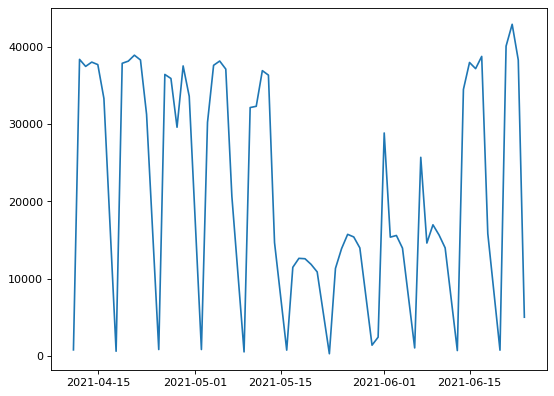

In [2]:
from sqlalchemy import create_engine
import pandas as pd
from os import environ
from dotenv import load_dotenv
load_dotenv()
live_engine = create_engine(environ.get("LIVE_DATABASE_URL"))

print(pd.read_sql("""
    select count(*) from rss_docket_entries 
    where
        pub_date > %(start_date)s
    """, live_engine, params={"start_date": "2021-05-10"})
)
date_counts = pd.read_sql("""
    select date(pub_date) date, count(*) count from rss_docket_entries 
    where
        pub_date > %(start_date)s
    
    group by date(pub_date);
    """, live_engine, params={"start_date": "2021-04-10"})

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6), dpi=80)

plt.plot(date_counts["date"], date_counts["count"])
plt.show()


In [6]:
pd.read_sql("""select * from rss_docket_entries limit 2""", live_engine)

,title,case_number,case_name,docket_id,description,document_type,guid,pub_date,court,scrape_date,docket_entry_seq_num,docket_entry_num
0,3:20-cr-03261-1 USA v. Aguilar,3:20-cr-03261-1,USA v. Aguilar,690972,[Notice of Lodgment of Plea Agreement] (<a hre...,Notice of Lodgment of Plea Agreement,https://ecf.casd.uscourts.gov/cgi-bin/DktRpt.p...,2021-04-09 00:08:01,casd,2021-04-09 22:24:57.933964,93,24
1,3:20-cr-03039-1 USA v. Diaz,3:20-cr-03039-1,USA v. Diaz,688904,"[Sentencing Summary Chart] (<a href=""https://e...",Sentencing Summary Chart,https://ecf.casd.uscourts.gov/cgi-bin/DktRpt.p...,2021-04-09 00:05:45,casd,2021-04-09 22:24:57.938230,97,34
